# **Modelado - `02_modelado.ipynb`**

### 🎯 **Objetivo**
En este notebook, entrenaremos y evaluaremos **modelos de clasificación binaria** para detectar eventos de movimiento de la mano a partir de **señales EEG**.

📌 **Los datos ya han sido preprocesados** en `01_preprocesamiento.ipynb` y están listos para su uso.

---

### ⚙️ **Selección de Modelos Base**
Dado que se trata de **un problema de clasificación binaria**, comenzaremos con dos modelos base bien establecidos:

- **🔍 Regresión Logística:**  
  - Modelo simple e interpretable.  
  - Funciona bien cuando los datos tienen relaciones lineales con la variable objetivo.  
  - Buen punto de partida antes de probar modelos más complejos.  
&nbsp; 
- **🌲 Random Forest:**  
  - Modelo más flexible que captura relaciones no lineales.  
  - Maneja bien características correlacionadas, algo común en señales EEG.  
  - Menos sensible a ruido y valores atípicos.  

Probaremos ambos modelos y compararemos su desempeño con **AUC-ROC**.
Comenzar con estos modelos nos permite evaluar rápidamente el desempeño y establecer una línea base antes de explorar opciones más avanzadas como **Redes Neuronales o XGBoost**.

---

### 🚀 **Flujo de Trabajo en este Notebook**
1️⃣ **Cargar los datos preprocesados**  
2️⃣ **Entrenar modelos base por cada evento y evaluar el desempeño con AUC-ROC**  
3️⃣ **Comparar los modelos**  
4️⃣ **Guardar los modelos entrenados**   
5️⃣ **Conclusiones y próximos pasos** 

## **1. Carga de Datos Preprocesados**

In [4]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [5]:
# Cargar datos preprocesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
with open(os.path.join(processed_path, "preprocessed_data.pkl"), "rb") as f:
    X_train, y_train, X_valid, y_valid = pickle.load(f)

# Revisar las dimensiones de los datos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_valid: {X_valid.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_valid: {y_valid.shape}")

Tamaño de X_train: (1185498, 32)
Tamaño de X_valid: (236894, 32)
Tamaño de y_train: (1185498, 6)
Tamaño de y_valid: (236894, 6)


Hemos cargado correctamente los datos preprocesados y podemos observar sus dimensiones:

- **X_train**: `(1,185,498, 32)` → 1,185,498 muestras de entrenamiento con 32 características EEG cada una.  
- **X_valid**: `(236,894, 32)` → 236,894 muestras de validación con las mismas 32 características.  
- **y_train**: `(1,185,498, 6)` → 1,185,498 etiquetas de entrenamiento para los 6 eventos de movimiento.  
- **y_valid**: `(236,894, 6)` → 236,894 etiquetas de validación para los mismos eventos.  

🟢**Confirmamos que los tamaños coinciden**, lo que significa que tenemos las mismas filas en `X_train` y `y_train`, así como en `X_valid` y `y_valid`.

## **2. Entreno de los Modelos Base y Evaluación con AUC-ROC**

Cada columna de `y_train` representa un evento distinto, por lo que tenemos **6 problemas de clasificación binaria independientes**. Dado que cada evento puede ocurrir de forma separada, entrenamos un modelo específico para cada uno en lugar de tratarlo como un solo problema multiclase.  

Para abordar estos problemas, utilizamos dos enfoques:  

- **Regresión Logística:** Modelo lineal eficiente e interpretable, útil cuando las relaciones entre las características y los eventos son aproximadamente lineales.  
- **Random Forest:** Modelo basado en múltiples árboles de decisión, capaz de capturar relaciones no lineales y manejar mejor la variabilidad de los datos.  

Cada modelo se entrena por separado para cada evento. Luego, se generan predicciones sobre el conjunto de validación y se evalúan usando **AUC-ROC**, una métrica que mide la capacidad del modelo para diferenciar entre las clases positiva y negativa.  

Los valores de AUC-ROC obtenidos se almacenan en **`resultados_auc`**, permitiendo comparar el rendimiento de cada modelo en los distintos eventos.  

Al final de este paso, habremos entrenado **12 modelos** (6 eventos × 2 modelos cada uno) y registrado **12 evaluaciones de AUC-ROC** para su análisis posterior.  


In [6]:
# Definir modelos base
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Diccionarios para guardar resultados
resultados_auc = {modelo: {} for modelo in modelos.keys()}  # AUC-ROC por modelo y evento
modelos_entrenados = {modelo: {} for modelo in modelos.keys()}  # Modelos guardados

# Entrenar ambos modelos para cada evento
for evento in y_train.columns:
    print(f"Entrenando modelos para el evento: {evento}")

    for nombre_modelo, modelo in modelos.items():
        print(f" → Entrenando {nombre_modelo}...")

        # Crear una copia del modelo
        modelo_instancia = modelo.fit(X_train, y_train[evento])

        # Guardar el modelo entrenado
        modelos_entrenados[nombre_modelo][evento] = modelo_instancia

        # Obtener predicciones de probabilidad
        y_pred_proba = modelo_instancia.predict_proba(X_valid)[:, 1]

        # Calcular AUC-ROC
        auc = roc_auc_score(y_valid[evento], y_pred_proba)
        resultados_auc[nombre_modelo][evento] = auc

        print(f" {nombre_modelo} - AUC-ROC para {evento}: {auc:.4f}")

Entrenando modelos para el evento: HandStart
 → Entrenando RandomForest...
 RandomForest - AUC-ROC para HandStart: 0.6363
 → Entrenando LogisticRegression...
 LogisticRegression - AUC-ROC para HandStart: 0.7168
Entrenando modelos para el evento: FirstDigitTouch
 → Entrenando RandomForest...
 RandomForest - AUC-ROC para FirstDigitTouch: 0.6297
 → Entrenando LogisticRegression...
 LogisticRegression - AUC-ROC para FirstDigitTouch: 0.6901
Entrenando modelos para el evento: BothStartLoadPhase
 → Entrenando RandomForest...
 RandomForest - AUC-ROC para BothStartLoadPhase: 0.6241
 → Entrenando LogisticRegression...
 LogisticRegression - AUC-ROC para BothStartLoadPhase: 0.6854
Entrenando modelos para el evento: LiftOff
 → Entrenando RandomForest...
 RandomForest - AUC-ROC para LiftOff: 0.6749
 → Entrenando LogisticRegression...
 LogisticRegression - AUC-ROC para LiftOff: 0.7473
Entrenando modelos para el evento: Replace
 → Entrenando RandomForest...
 RandomForest - AUC-ROC para Replace: 0.8153

## **3. Comparación de los Modelos**

Los valores obtenidos y almacenados en `resultados_auc` se convierten en un **DataFrame de Pandas (`df_auc`)** para facilitar su análisis y visualización.  

Para comparar los modelos de forma gráfica, se genera un **gráfico de barras**, donde:  

- Cada barra representa el **AUC-ROC obtenido por un modelo en un evento**.  
- Se utiliza la paleta **"coolwarm"** para diferenciar modelos.  
- Se establecen límites en el eje Y entre **0.5 y 1**, ya que valores por debajo de 0.5 indican que el modelo es peor que el azar.  
- Se añade una **cuadrícula** para facilitar la comparación visual.  

Este análisis permite identificar **qué modelo funciona mejor para cada evento** y en cuáles es necesario mejorar el rendimiento.  


<Figure size 1000x500 with 0 Axes>

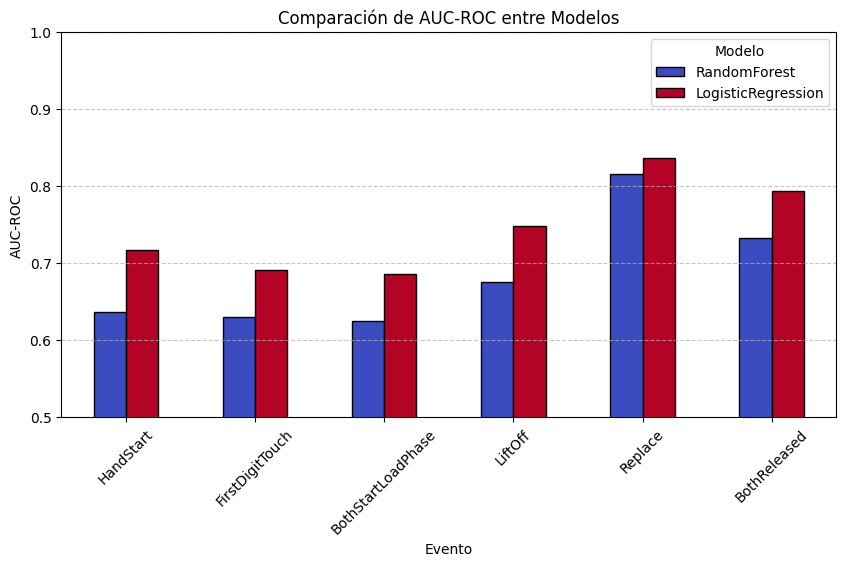

In [8]:
# Convertir resultados en DataFrame para mejor visualización
df_auc = pd.DataFrame(resultados_auc)

# Graficar comparativa de AUC-ROC por evento y modelo
plt.figure(figsize=(10, 5))
df_auc.plot(kind="bar", figsize=(10, 5), colormap="coolwarm", edgecolor="black")
plt.xlabel("Evento")
plt.ylabel("AUC-ROC")
plt.title("Comparación de AUC-ROC entre Modelos")
plt.ylim(0.5, 1)  # AUC va de 0.5 (aleatorio) a 1 (perfecto)
plt.xticks(rotation=45)
plt.legend(title="Modelo")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



# Definir ruta para guardar los modelos
model_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\models"
os.makedirs(model_path, exist_ok=True)

# Guardar datos en Pickle
with open(os.path.join(model_path, "modelos_entrenados.pkl"), "wb") as f:
    pickle.dump(modelos_entrenados, f)
    
df_auc.to_csv(os.path.join(processed_path, "resultados_auc.csv"), index=True)

### Análisis de Resultados y Consideraciones para Próximos Modelos  

Los resultados muestran que **la Regresión Logística ha superado a Random Forest en todos los eventos**, lo que sugiere que las relaciones entre las señales EEG y los eventos pueden ser **más lineales de lo esperado**.  

#### Observaciones Clave  
- **Los eventos `Replace` y `BothReleased` tienen mejor desempeño** (AUC-ROC > 0.8), lo que indica que los patrones en las señales EEG son más distinguibles para estos eventos.  
- **Los eventos `FirstDigitTouch`, `BothStartLoadPhase` y `HandStart` muestran menor desempeño** (AUC-ROC en torno a 0.63 - 0.71), lo que sugiere que pueden ser más difíciles de predecir debido a una señal EEG más difusa o poco diferenciada.  

#### Optimización del Tiempo de Entrenamiento  

El entrenamiento ha tardado **una hora**, debido principalmente a **Random Forest**, que ha tardado aproximadamente **10 minutos por evento**, mientras que **Regresión Logística completó cada evento en solo unos segundos**. Dado que Random Forest ha mostrado un peor desempeño y un costo computacional alto, es recomendable ajustar la estrategia para futuras pruebas.  

Algunas alternativas para reducir el tiempo de entrenamiento sin comprometer la calidad de los resultados incluyen:  

1. **Reducir la cantidad de datos de entrenamiento:**  
   - En lugar de entrenar con **6 series y evaluar con 2**, probar con **3 series de entrenamiento y 1 de validación** para evaluar si los resultados se mantienen estables con menos datos, permitiendo iteraciones más rápidas.  
   - Esto permitiría hacer pruebas más rápidas sobre diferentes modelos e hiperparámetros antes de escalar el entrenamiento completo.  
&nbsp; 
2. **Evitar Random Forest y probar modelos más eficientes:**  
   - **XGBoost o LightGBM** pueden ofrecer mejor rendimiento con menor tiempo de entrenamiento.  
&nbsp; 
3. **Optimizar hiperparámetros de Regresión Logística:**  
   - Como ha mostrado mejor desempeño y es mucho más rápido, ajustar el hiperparámetro `C` (regularización) podría mejorar aún más los resultados sin necesidad de modelos más complejos.

### **Estrategia para la Optimización y Combinación de Predicciones**

#### **Evaluación de los Primeros Modelos**
Hemos probado dos modelos de Machine Learning para la detección de eventos en EEG:
- **Regresión Logística**
- **Random Forest**

Los resultados mostraron que **Regresión Logística obtuvo mejores métricas en todos los eventos**, por lo que descartamos Random Forest y nos enfocamos en mejorar el rendimiento de la Regresión Logística antes de combinar las predicciones.

---

#### **¿Optimizar antes o después de combinar predicciones?**
Al enfrentar un problema de clasificación multietiqueta (seis eventos independientes), hay dos posibles estrategias:

1. **Evaluar y combinar predicciones antes de optimizar** (Estrategia Inicial):
   - Entrenar modelos base para cada evento.
   - Evaluar cada modelo individualmente con AUC-ROC.
   - Combinar las predicciones de los seis modelos y evaluar el resultado conjunto.
   - Si la combinación no da buenos resultados, optimizar los modelos individuales.

   Esto permite identificar si la mejora está en la combinación de predicciones en lugar de en los modelos individuales, pero si los modelos base no son    lo suficientemente buenos, la combinación de predicciones tampoco lo será.

2. **Optimizar un poco antes de combinar predicciones** (Estrategia Ajustada):
   - Si los modelos individuales tienen un AUC bajo, es mejor **optimizar primero** antes de combinarlos.
   - Ajustar **hiperparámetros** como la regularización (`C`, `l1/l2`).
   - Evaluar si los modelos optimizados realmente mejoran.
   - Combinar predicciones y analizar si hay conflictos o patrones en los eventos detectados.
   - Si después de combinar las predicciones la métrica AUC aún no es buena, probar modelos más avanzados (XGBoost, Redes Neuronales, etc.).

   Esto permite mejorar la calidad de cada modelo antes de fusionar las predicciones, pero puede consumir más tiempo si la optimización no aporta           mejoras significativas.

#### **Decisión: Seguimos la Segunda Estrategia**
Dado que **los modelos actuales tienen un AUC en torno a 0.7, lo que no es suficientemente alto**, y que, por lo general, es muy difícil que la combinación de predicciones por sí sola consiga aumentar significativamente la métrica hasta niveles óptimos (de ≈0.7 a ≈0.95, que es lo que nos interesa), **optimizaremos primero la Regresión Logística antes de combinar predicciones**.  

---

#### **Plan de Acción**

✅ **1️⃣ Optimizar la Regresión Logística con GridSearchCV** para ajustar hiperparámetros (`C`, `l1/l2`).   
✅ **2️⃣ Evaluar de nuevo cada modelo individual** después de la optimización.   
✅ **3️⃣ Valorar si combinar las predicciones de los seis modelos** y analizar la coherencia entre eventos, o antes hacer ajustes adicionales en preprocesado/ probar modelos más avanzados** (XGBoost, Redes Neuronales, etc.).   

---

**Continuamos en `03_optimizacion.ipynb` para ajustar la Regresión Logística y mejorar su rendimiento.**